In [1]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

In [ ]:
gamma_opt = 2*np.pi * 0.04    #frequencies in GHz
Delta_opt = 2*np.pi * 4.
kappa_opt = 2*np.pi * 0.01

gamma_v = 2*np.pi * 6.
Delta_v = 2*np.pi * 4.
n_th = 0
kappa_v = 2*np.pi * .01

Nvib = 30
sig = tensor( sigmam(), qeye(Nvib))
b = tensor(qeye(2), destroy(Nvib))

eta = 0.3
sig_p = sig * tensor(qeye(2), displace(Nvib, eta))  

Gamma_plus = 0


arr_g = 2*np.pi * np.linspace(.1, 20, 30)
arr_Sq = []
arr_Sq_avg = []

for g in arr_g:

    H0 = Delta_v*b.dag()*b + Delta_opt*sig.dag()*sig 
    H_AS = g/2*( sig*b + sig.dag()*b.dag() )
    H_S = g/2.*( sig*b.dag() + sig.dag()*b )
    HR_2 = .1 * g/2.*( sig.dag() * b*b + sig * b.dag()*b.dag() )
    HAR_2 = .1 * g/2.*( sig.dag() * b.dag()*b.dag() + sig * b*b )

    Hin = H0 + (H_S + H_AS) + (HR_2 + 0*HAR_2) + .0*g/2*(sig + sig.dag())
    c_jumps = [ np.sqrt(gamma_v*(1 + n_th))*b, np.sqrt(gamma_v*(n_th))*b.dag(), np.sqrt(kappa_v)*b.dag()*b, np.sqrt(gamma_opt)*sig, np.sqrt(Gamma_plus)*sig.dag(), np.sqrt(kappa_opt)*sig.dag()*sig ]
    
    evals, evecs = Hin.eigenstates(sort='low')

    c = sig
    e_ops = []
    c0_ran = np.random.rand(5)
    psi0 = 1*evecs[0]
    for nc0 in range(1,len(c0_ran)-1):
        psi0 += c0_ran[nc0]*evecs[nc0]
    psi0 = psi0/np.sqrt(np.abs(psi0.overlap(psi0)))

    Ntimes = 50
    tlist = np.linspace(0, 20, Ntimes)  # in ns
    Ntraj = 40
    Sq = 0
    
    #options = Options(num_cpus=3, gui=False, atol=1e-10)
    options = Options(atol=1e-6, norm_t_tol=1e-8, norm_tol=1e-4)
    rho_ss_avg = 0*(psi0 * psi0.dag())
    for ntraj in range(Ntraj):
        sol = mcsolve(Hin, psi0, tlist, c_jumps, e_ops, ntraj=1, options=options)
        F = sol.expect
        psi_t = sol.states
        psi_ss = psi_t[Ntimes-1]
        rho_ss = psi_ss * psi_ss.dag()
        rho_ss_avg += rho_ss/Ntraj
        Sq += entropy_vn( rho_ss.ptrace(0) )/Ntraj

    arr_Sq.append(Sq)
    arr_Sq_avg.append( entropy_vn( rho_ss_avg.ptrace(0) ) )
    print("=======================> %.2f %% \r" % (100*g/np.amax(arr_g)) )

arr_Sq = np.asarray(arr_Sq)    
arr_Sq_avg = np.asarray(arr_Sq_avg)    
    
    

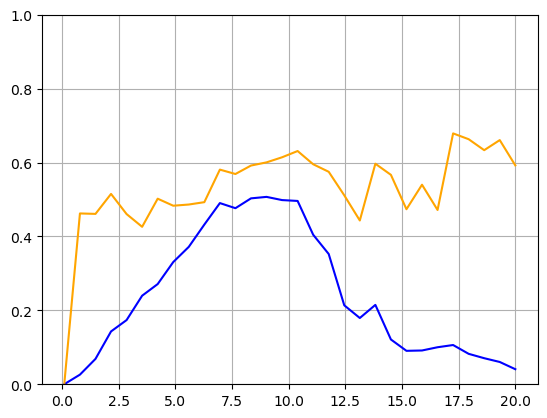

In [148]:
plt.plot(arr_g/(2*np.pi), arr_Sq, color='blue')
plt.plot(arr_g/(2*np.pi), arr_Sq_avg, color='orange')

plt.ylim((0,1))
plt.grid()

In [38]:
gamma_opt = 2*np.pi * 0.04    #frequencies in GHz
Delta_opt = 2*np.pi * 0
kappa_opt = 2*np.pi * 0.0

gamma_v = 2*np.pi * 10.
Delta_v = 2*np.pi * 4
n_th = 0
kappa_v = 2*np.pi * .0

Nvib = 50
sig = tensor( sigmam(), qeye(Nvib))
b = tensor(qeye(2), destroy(Nvib))

IDq = tensor(qeye(2), qeye(Nvib))

eta = 0.3
sig_p = sig * tensor(qeye(2), displace(Nvib, eta))

Gamma_plus = 0

delta_omega = 2*np.pi * 20


g = 2*np.pi * 20
g2S = 2*np.pi * 0
g2A = 2*np.pi * 0
gTHz = 2*np.pi * 0.
g2DS = 2*np.pi * 0

H0 = Delta_v*b.dag()*b + Delta_opt*sig.dag()*sig + delta_omega * sig.dag()*sig*b.dag()*b
H_AS = g/2*( sig*b + sig.dag()*b.dag() )
H_S = g/2.*( sig*b.dag() + sig.dag()*b )
HR_2 = eta/2 * g2S/2.*( sig.dag()*b*b + sig*b.dag()*b.dag() )
HAR_2 = eta/2 * g2A/2.*( sig.dag()*b.dag()*b.dag() + sig*b*b )
HD_S = eta/2 * g2DS/2.*( sig.dag()*b*b + sig*b.dag()*b.dag() + (sig.dag()+sig)*b.dag()*b )

Hin = H0 + (H_S + H_AS) + (HR_2 + HAR_2) + gTHz/2.*(b+b.dag())
c_jumps = [ np.sqrt(gamma_v*(1 + n_th))*b, np.sqrt(gamma_v*(n_th))*b.dag(), np.sqrt(kappa_v)*b.dag()*b, np.sqrt(gamma_opt)*sig, np.sqrt(Gamma_plus)*sig.dag(), np.sqrt(kappa_opt)*sig.dag()*sig ]

evals, evecs = Hin.eigenstates(sort='low')

c = sig*b
c0 = sig
ch = sig 
c_SAS = b
Parity = ( 1j*np.pi*(b.dag()*b + sig.dag()*sig) ).expm()
#e_ops = []
e_ops = [c0.dag()*c0, c.dag()*c, (c_SAS+c_SAS.dag()), (ch+ch.dag()), Parity ]


c0_ran = np.random.rand(5)
psi0 = 1*evecs[0]
for nc0 in range(1,len(c0_ran)-1):
    psi0 += c0_ran[nc0]*evecs[nc0]              #initialize psi0 in a partially random state at low energy
psi0 = psi0/np.sqrt(np.abs(psi0.overlap(psi0))) #normalize it
psi0 = .5*(IDq - Parity)*psi0                   #project psi0 on a well defined parity sector (to go faster to steady state)
psi0 = psi0/np.sqrt(np.abs(psi0.overlap(psi0))) #normalize
print( np.abs(psi0.overlap(psi0)) )             #verify normalization

Ntimes = 100000
tlist = np.linspace(0, 30, Ntimes)  # in ns
Ntraj = 1

#options = Options(num_cpus=3, gui=False, atol=1e-10)
options = Options(atol=1e-8, norm_t_tol=1e-10, norm_tol=1e-6)

#arr_Sq = []
#arr_cexp = []
#arr_c0exp = []
for ntraj in range(Ntraj):
    sol = mcsolve(Hin, psi0, tlist, c_jumps, e_ops, ntraj=1, options=options)
    F0 = sol.expect[0]
    F = sol.expect[1]
    Fhomodyn = sol.expect[2]
    FhomoQ = sol.expect[3]
    PP_avg = sol.expect[4]
    #psi_t = sol.states
    #psi_ss = psi_t[Ntimes-1]
    #rho_ss = psi_ss * psi_ss.dag()
    #Sq = entropy_vn( rho_ss.ptrace(0) )
    #arr_cexp.append( np.abs( expect(c.dag()*c, psi_ss) ) )
    #arr_c0exp.append( ( expect(c0.dag()+c0, psi_ss) ) )
    #arr_Sq.append(Sq)
    print("=====================================================================> %.2f %% \r" % (100*ntraj/Ntraj))
    
    


0.9999999999999997
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   5.69s
=====================================================================> 0.00 % 


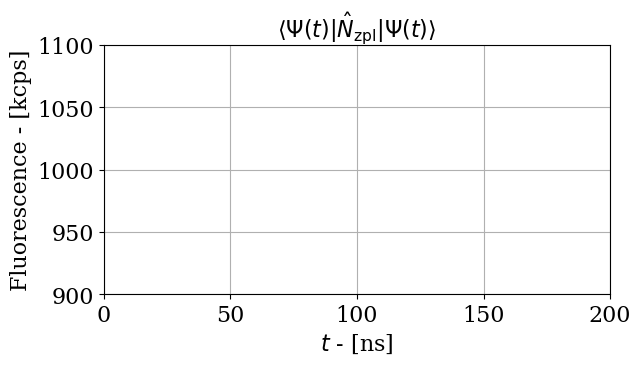

In [39]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

p_click= 0.05
plt.plot(tlist-100, p_click*gamma_opt/(2*np.pi)*np.abs(F0) * 1e6, color='blue')
#plt.plot(tlist-100, p_click*eta**2*gamma_opt/(2*np.pi)*np.abs(F)* 1e6, label=r'$\langle{\Psi(t)| \hat{N}_{\rm AS}| \Psi(t)\rangle}$', color='red')

plt.title(r'$\langle{\Psi(t)| \hat{N}_{\rm zpl}| \Psi(t)\rangle}$', fontdict=font)

plt.xlim((00,200))
plt.ylim((900,1100))

plt.xlabel(r'$t$ - [ns]', fontdict=font)
plt.ylabel(r'Fluorescence - [kcps]', fontdict=font)

#plt.legend( fontsize=12)


plt.grid()
plt.gcf().set_size_inches(170 / 25.4, 100 / 25.4)  # Convert mm to inches
plt.tight_layout()

plt.show()

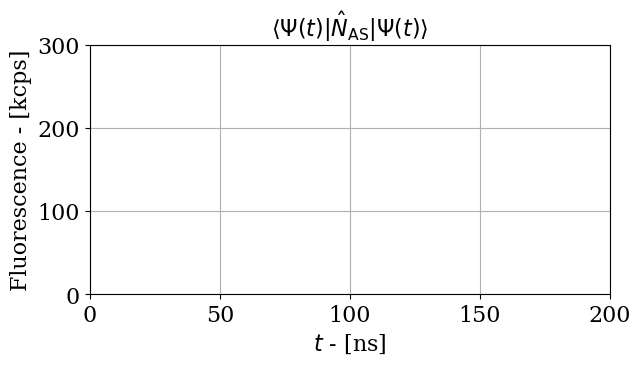

In [40]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

p_click= 0.05
#plt.plot(tlist-100, p_click*gamma_opt/(2*np.pi)*np.abs(F0) * 1e6, label=r'$\langle{\Psi(t)| \hat{N}_{\rm zpl}| \Psi(t)\rangle}$', color='blue')
plt.plot(tlist-100, p_click*eta**2*gamma_opt/(2*np.pi)*np.abs(F)* 1e6, color='red')

plt.title(r'$\langle{\Psi(t)| \hat{N}_{\rm AS}| \Psi(t)\rangle}$', fontdict=font)


plt.xlim((00,200))
plt.ylim((0,300))

plt.xlabel(r'$t$ - [ns]', fontdict=font)
plt.ylabel(r'Fluorescence - [kcps]', fontdict=font)

#plt.legend( fontsize=12)


plt.grid()
plt.gcf().set_size_inches(170 / 25.4, 100 / 25.4)  # Convert mm to inches
plt.tight_layout()

plt.show()

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_18063/1171754429.py:42: UserWarning:

The figure layout has changed to tight



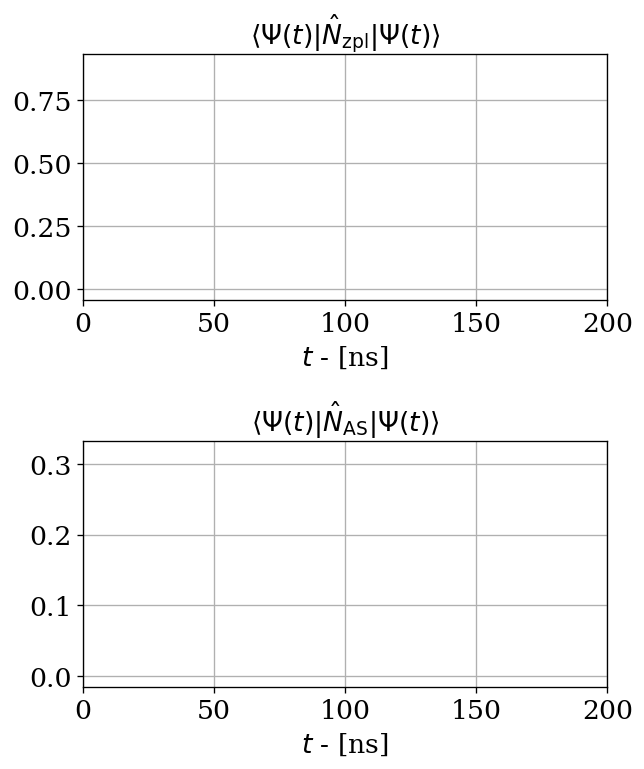

In [41]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

p_click = 0.05

# Create the figure and axes for subplots
fig, axes = plt.subplots(2, 1, figsize=(170 / 25.4, 200 / 25.4), dpi=120, constrained_layout=True)

# Plot 1: Upper plot
#axes[0].plot(tlist - 100, p_click * gamma_opt / (2 * np.pi) * np.abs(F0) * 1e6, color='blue')
axes[0].plot(tlist - 100, np.abs(F0), color='blue')
axes[0].set_title(r'$\langle{\Psi(t)| \hat{N}_{\rm zpl}| \Psi(t)\rangle}$', fontdict=font)
axes[0].set_xlim((0, 200))
#axes[0].set_ylim((0.3, .7))
axes[0].set_xlabel(r'$t$ - [ns]', fontdict=font)
#axes[0].set_ylabel(r'Fluorescence - [kcps]', fontdict=font)
axes[0].grid()

# Plot 2: Lower plot
axes[1].plot(tlist - 100, np.abs(F), color='red')
axes[1].set_title(r'$\langle{\Psi(t)| \hat{N}_{\rm AS}| \Psi(t)\rangle}$', fontdict=font)
axes[1].set_xlim((0, 200))
#axes[1].set_ylim((1, 1.5))
axes[1].set_xlabel(r'$t$ - [ns]', fontdict=font)
#axes[1].set_ylabel(r'Fluorescence - [kcps]', fontdict=font)
axes[1].grid()

#plt.grid()
plt.gcf().set_size_inches(140 / 25.4, 170 / 25.4)  # Convert mm to inches
plt.tight_layout()

#plt.savefig("v2_blinking_Delta%.2f_gAS2_%.2f_eta%.2fv2.svg" % (Delta_v/(2*np.pi), g2A/(2*np.pi), eta) )

plt.show()

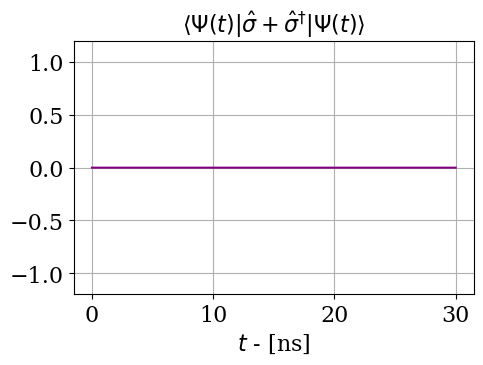

In [42]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

plt.plot(tlist, (FhomoQ), color='purple')

plt.title(r'$\langle{\Psi(t)| \hat{\sigma} + \hat{\sigma}^{\dag} | \Psi(t)\rangle}$', fontdict=font)

#plt.xlim((00,200))
plt.ylim((-1.2,1.2))

plt.xlabel(r'$t$ - [ns]', fontdict=font)
#plt.ylabel(r'Fluorescence - [kcps]', fontdict=font)

#plt.legend( fontsize=12)


plt.grid()
plt.gcf().set_size_inches(130 / 25.4, 100 / 25.4)  # Convert mm to inches
plt.tight_layout()
#plt.savefig("v2homo_blinking_Delta%.2f_gAS2_%.2f_eta%.2f.pdf" % (Delta_v/(2*np.pi), g2A/(2*np.pi), eta) )
plt.show()


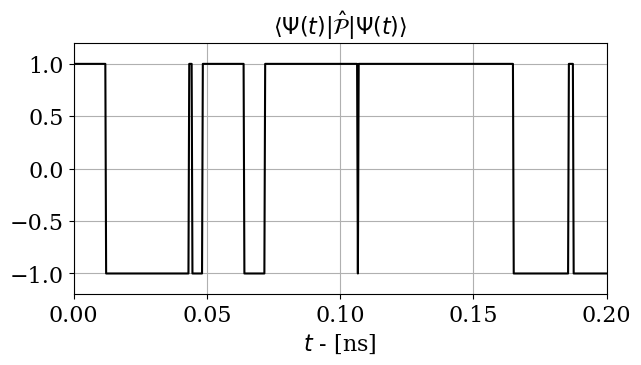

In [43]:


# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

plt.plot(tlist-1750/gamma_v, (PP_avg), color='black', linestyle='-')

plt.title(r'$\langle{\Psi(t)| \hat{\mathcal{P}}  | \Psi(t)\rangle}$', fontdict=font)

plt.xlim((00,0.2))
plt.ylim((-1.2,1.2))

plt.xlabel(r'$t$ - [ns]', fontdict=font)
#plt.ylabel(r'Fluorescence - [kcps]', fontdict=font)

#plt.legend( fontsize=12)


plt.grid()
plt.gcf().set_size_inches(170 / 25.4, 100 / 25.4)  # Convert mm to inches
plt.tight_layout()
#plt.savefig("parity_blinking_Delta%.2f_gAS2_%.2f_eta%.2f.pdf" % (Delta_v/(2*np.pi), g2A/(2*np.pi), eta) )
plt.show()


In [510]:
from joblib import Parallel, delayed

Ntraj = 200
Ntimes = 800
tlist = np.linspace(0, 100, Ntimes)  # in ns

# Define a function for the computation of a single trajectory
def compute_trajectory(ntraj):
    sol = mcsolve(Hin, psi0, tlist, c_jumps, [], ntraj=1, options=options)
    psi_t = sol.states
    psi_ss = psi_t[Ntimes - 1]
    rho_ss = psi_ss * psi_ss.dag()
    Sq = entropy_vn(rho_ss.ptrace(0))
    cexp = np.abs(expect(c.dag() * c, psi_ss))
    c0exp = expect(c0.dag()*c0, psi_ss)
    homoc0exp = expect(c0.dag()+c0, psi_ss)
    return Sq, cexp, c0exp, homoc0exp

# Use joblib to parallelize the loop
results = Parallel(n_jobs=5)(
    delayed(compute_trajectory)(ntraj) for ntraj in range(Ntraj)
)

# Aggregate the results
arr_Sq, arr_cexp, arr_c0exp, arr_homoc0exp = zip(*results)
arr_Sq = list(arr_Sq)
arr_cexp = list(arr_cexp)
arr_c0exp = list(arr_c0exp)
arr_homoc0exp = list(arr_homoc0exp)

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   6.81s
Total run time:   6.82s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   7.06s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   7.18s
Total run time:   7.20s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   7.49s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   7.72s
Total run time:   7.46s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   7.51s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Total run time:   6.99s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   7.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   6.87s
Total run time:   6.84s
Total run time:   6.88s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   6.75s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   6.87s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   6.84s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   6.73s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   6.95s
Total run time:   6.99s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   6.85s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_8612/3293962298.py:26: UserWarning:

The figure layout has changed to tight



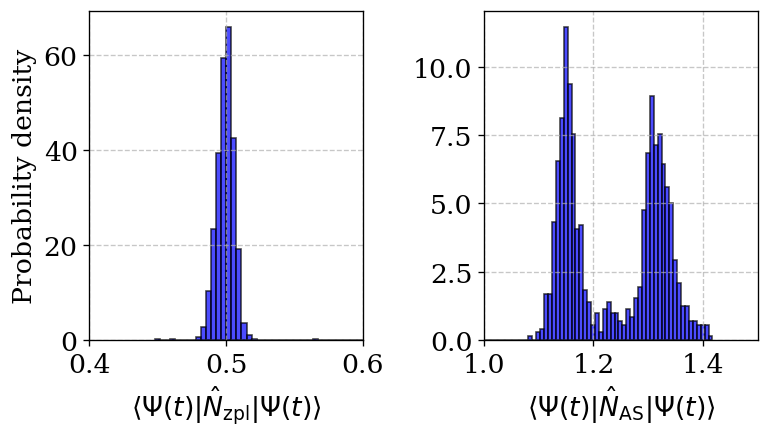

In [558]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=120, constrained_layout=True)

# Plot 2: Histogram of arr_c0exp (on the left)
axes[0].hist(arr_c0exp, bins=50, color='blue', edgecolor='black', alpha=0.7, density=True)
axes[0].set_xlabel(r'$\langle{\Psi(t)| \hat{N}_{\rm zpl}| \Psi(t)\rangle}$', fontdict=font)
axes[0].set_ylabel('Probability density', fontdict=font)
axes[0].set_xlim((0.4, 0.6))
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 1: Histogram of arr_cexp (on the right)
axes[1].hist(arr_cexp, bins=150, color='blue', edgecolor='black', alpha=0.7, density=True)
axes[1].set_xlabel(r'$\langle{\Psi(t)| \hat{N}_{\rm AS}| \Psi(t)\rangle}$', fontdict=font)
#axes[1].set_ylabel('Probability density', fontdict=font)
axes[1].set_xlim((1, 1.5))
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.gcf().set_size_inches(170 / 25.4, 100 / 25.4)  # Convert mm to inches
plt.tight_layout()

#plt.savefig("zpl_AS_probability_density.pdf")

plt.show()


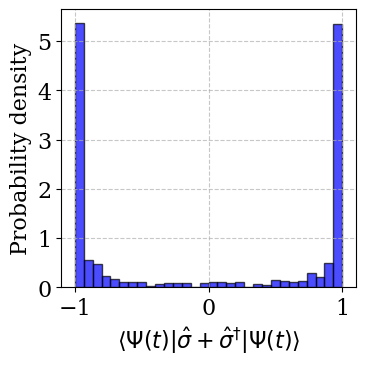

In [559]:
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(arr_homoc0exp, bins=30, color='blue', edgecolor='black', alpha=0.7, density=True)

# Add labels and title
plt.xlabel(r'$\langle{\Psi(t)| \hat{\sigma}+\hat{\sigma}^{\dag}| \Psi(t)\rangle}$', fontdict=font)
plt.ylabel('Probability density', fontdict=font)
#plt.title('Histogram of c0.dag + c0', fontdict=font)
#plt.xlim((0,3))
# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.gcf().set_size_inches(100 / 25.4, 100 / 25.4)  # Convert mm to inches
plt.tight_layout()

#plt.savefig("homozpl_probability_density.pdf")

plt.show()

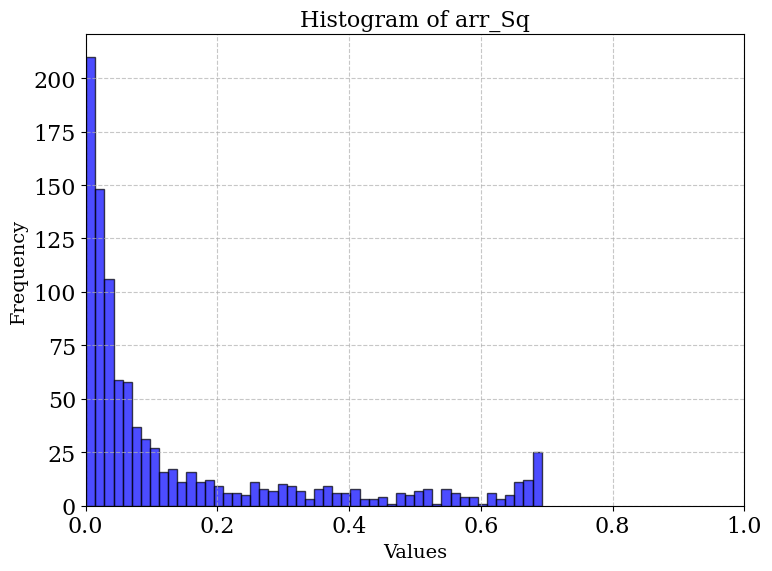

In [511]:
# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(arr_Sq, bins=50, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of arr_Sq', fontsize=16)
plt.xlim((0,1))
# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

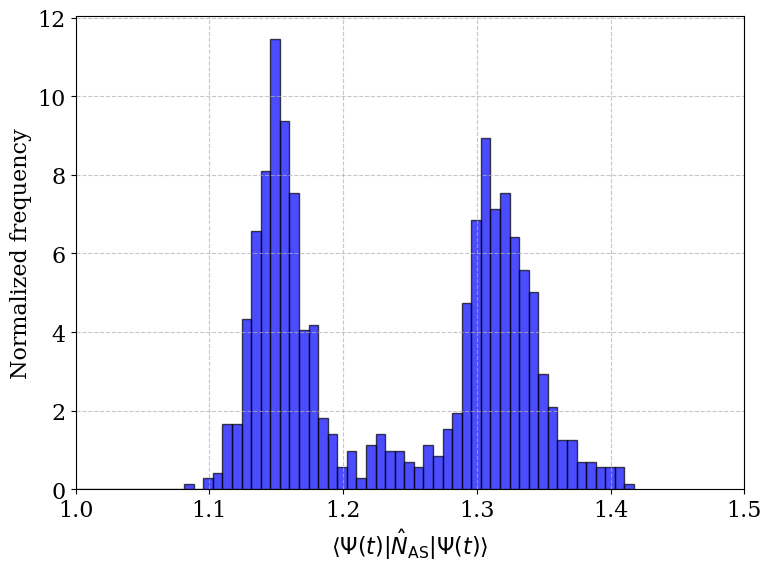

In [538]:
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(arr_cexp, bins=150, color='blue', edgecolor='black', alpha=0.7, density=True)

# Add labels and title
plt.xlabel(r'$\langle{\Psi(t)| \hat{N}_{\rm AS}| \Psi(t)\rangle}$', fontdict=font)
plt.ylabel('Probability density',fontdict=font)
#plt.title('Histogram of c.dag c', fontdict=font)
plt.xlim((0,3))
# Show grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim((1,1.5))
# Display the plot
plt.tight_layout()
plt.show()

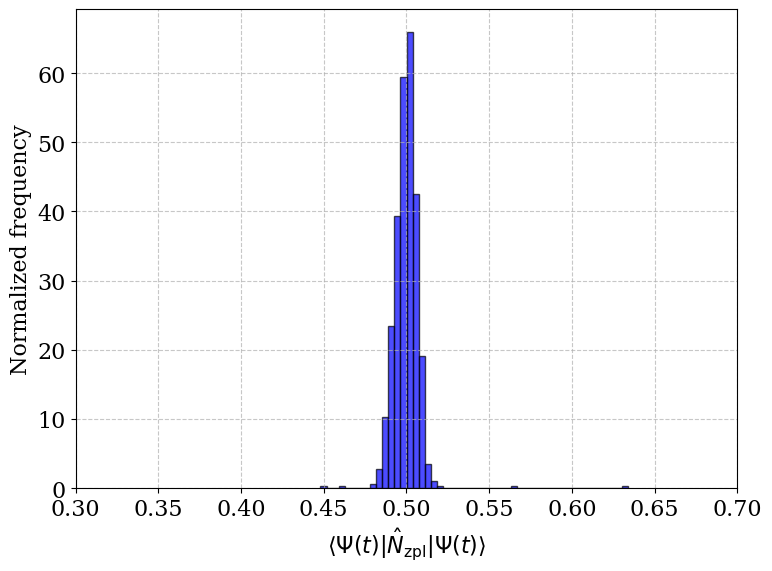

In [539]:
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(arr_c0exp, bins=50, color='blue', edgecolor='black', alpha=0.7, density=True)

# Add labels and title
plt.xlabel(r'$\langle{\Psi(t)| \hat{N}_{\rm zpl}| \Psi(t)\rangle}$', fontdict=font)
plt.ylabel('Probability density', fontdict=font)
#plt.title('Histogram of c0.dag * c0', fontdict=font)
#plt.xlim((0,3))
# Show grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim((0.3,.7))
# Display the plot
plt.tight_layout()
plt.show()